# Model based collaborative system

### Matheus Gama dos Santos - 20180163117</br>Ewerton André de Sousa Moura - 20170018210

<font size='3'>&emsp;Este trabalho consiste na implementação de um sistema de recomendação colaborativo baseado em modelo, utilizando o módulo surprise e alguns módulos do pacote anaconda (pandas, numpy e matplotlib para display de imagem). A base utilizada foi a base MovieLens, gerenciada pelo laboratório GroupLens, da Universidade de Minnesota. A base possui pouco mais de 100.000 avaliações, mais de 9700 filmes e 610 usuários.</br>&emsp; Um Sistema de Recomendação combina várias técnicas computacionais para selecionar itens personalizados com base nos interesses dos usuários e conforme o contexto no qual estão inseridos. Tais itens podem assumir formas variadas como, por exemplo, livros, filmes, notícias, música, vídeos, anúncios, links patrocinados, páginas de internet, produtos de uma loja virtual, etc.</br>&emsp;Sistemas colaborativos baseados em modelo utilizam técnicas de Machine Learning considerando as ações passadas do usuário (no caso as avaliações) para tentar prever novas ações (como o usuário avaliaría um produto que ainda não teve contato).</font>

In [ ]:
!pip install surprise

In [2]:
# import core modules
import pandas as pd 
import numpy as np
from surprise import Reader, Dataset
from surprise import SVD
from surprise.accuracy import rmse, mae
from collections import defaultdict
import matplotlib.pyplot as plt

import matplotlib.image as mpimg
from IPython.display import display, Image

<font size='3'>Vamos importar os dois CSVs principais: ratings.csv e movies.csv</font>

In [3]:
# rating dataset
ratings = pd.read_csv ('data_movie/ratings.csv')

# movies dataset
movies = pd.read_csv('data_movie/movies.csv')

## Pre-processamento

<font size ='3'>&emsp;**ratings.csv** possui as colunas: userId, movieId, rating e timestamp.<br>&emsp;**movies.csv** possui as colunas: movieId, title e genres.<br>&emsp;O atributo movieId, da tabela ratings.csv, possui os valores correspondentes em movies.csv. Com o intuito de melhor visualizar e entender a base, vamos adicionar as colunas com títulos e gêneros correspondentes de cada filme.</font>

In [4]:
# adicionar o título e o gênero de cada filme através do movieId, que é comum às duas tabelas
dict_movies = {}
for index, row in movies.iterrows():
    dict_movies[row['movieId']] = (row['title'], row['genres'])

In [5]:
new_cols = np.zeros((ratings.shape[0] , 2)).astype('object')

for index, row in ratings.iterrows():
    new_cols[index][0] = dict_movies[int(row['movieId'])][0]
    new_cols[index][1] = dict_movies[int(row['movieId'])][1]

In [6]:
# compor dataframe final
aux = np.append(ratings.to_numpy(),new_cols, axis=1)
movielens_dataframe = pd.DataFrame(aux, columns = ['userId', 'movieId', 'rating', 'timestamp','title', 'genres'])
movielens_dataframe.drop(['timestamp'], axis=1, inplace=True)

In [7]:
movielens_dataframe['userId'] = movielens_dataframe['userId'].astype('int32')
movielens_dataframe['movieId'] = movielens_dataframe['movieId'].astype('int64')
movielens_dataframe['rating'] = movielens_dataframe['rating'].astype('float32')

In [8]:
# visualização do dataframe movielens, dropando o atributo timestamp, que é irrelevante para a análise dos dados e treino/teste em si
movielens_dataframe.head(15)

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
5,1,70,3.0,From Dusk Till Dawn (1996),Action|Comedy|Horror|Thriller
6,1,101,5.0,Bottle Rocket (1996),Adventure|Comedy|Crime|Romance
7,1,110,4.0,Braveheart (1995),Action|Drama|War
8,1,151,5.0,Rob Roy (1995),Action|Drama|Romance|War
9,1,157,5.0,Canadian Bacon (1995),Comedy|War


<font size='3'>&emsp;Vamos montar agora o que chamamos de matriz de avaliações, que é formada por avaliações vs usuários. Tendo os filmes como índices das colunas e usuários como índices das linhas, cada célula representa a nota desse usuário para o filme especificado nas colunas.<br>&emsp;Quando a matriz de avaliações contém em sua maioria valores nulos, dizemos que é uma matriz esparsa, caso contrário dizemos que ela é densa. Nesse caso, temos que a matriz é esparsa, o que é perfeitamente explicável já que primeiramente temos mais filmes que usuários e também é normal que os usuários não avaliem muitos filmes, comparado à quantidade de filmes disponíveis. A matriz gerada pode ser visualizada abaixo com 20 linhas de exemplo (sample).</font>

In [9]:
# matriz de ratings-users
movie_matrix = movielens_dataframe.pivot_table(index='userId', columns='title', values='rating')
movie_matrix.sample(20)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
279,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
352,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN
358,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
423,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
466,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.5,NaN,NaN,NaN
440,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
544,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
560,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN


### Distribuição dos Dados

<font size='3'>&emsp;Realizando estatística descritiva sobre a base de dados em questão, vamos avaliar o número de avaliações por usuário, o número de avaliações por filme e o número de filmes por nota (as notas varíam de 0.5 a 5.0, sempre com intervalos de 0.5).</font>

In [10]:
# número de avaliações por usuário
counts = movielens_dataframe['userId'].value_counts()
counts_median = counts.median()
counts.sample(13)

250     27
382    291
335     28
150     26
266    180
132    347
242     35
42     440
348     55
398     46
78      61
169    269
317    189
Name: userId, dtype: int64

In [11]:
counts.describe()

count     610.000000
mean      165.304918
std       269.480584
min        20.000000
25%        35.000000
50%        70.500000
75%       168.000000
max      2698.000000
Name: userId, dtype: float64

In [12]:
print("Mediana: "+ str(counts_median))

Mediana: 70.5


<font size='3'>&emsp;Temos como principais observações que cada usuário fez no mínimo 20 avaliações e metade dos usuários avaliou no máximo 70 filmes. Poucos valores são altos o suficiente para chamar atenção, talvez podendo ser chamados de outliers, porém dada a aproximação adotada para o problema (sistema colaborativo baseado em modelo) não só remover outliers iria acabar com a fidelidade da base, como o fato de ter valores altos em meio a valores baixos em maioria, não influencia no resultado como um todo. <br>&emsp;O fato de um usuário ter mais avaliações, só faz com que seja mais fácil definir o perfil desse usuário e mais fácil será realizar uma recomendação para ele.</font>

In [13]:
# em relação ao número de avaliações por filme
mv = movielens_dataframe.drop(['title','genres','userId'], axis=1)

# id do filme vs número de avaliações
mv = mv.groupby(['movieId']).count()
mv.sample(12)

,rating
movieId,
175577,1
2710,64
5404,3
6116,2
8967,4
85401,5
162414,1
104913,11
26340,3


In [14]:
mv.describe()

,rating
count,9724.000000
mean,10.369807
std,22.401005
min,1.000000
25%,1.000000
50%,3.000000
75%,9.000000
max,329.000000


In [15]:
mv_median = mv.median().tolist()[0]
print(f"Mediana: {mv_median}")

Mediana: 3.0


<font size='3'>&emsp;Podemos ver que 1/4 da base possui filmes com apenas uma avaliação e 3/4 com 9 ou menos avaliações. Se considerarmos todos os filmes presentes em movies.csv podemos ver que temos mais de 15 filmes sem avaliação alguma. Também temos um filme com mais de 300 avaliações, que poderia ser considerado um outlier por exemplo, porém a quantidade de avaliações por filme também não influencia no resultado final, dado que o perfil de cada usuário é compreendido singularmente e apenas suas próprias avaliações influenciam em suas recomendações.</font>

In [16]:
# em relação ao número de filmes avaliados para cada nota 
rt = movielens_dataframe.drop(['title','genres','userId'], axis=1)

# notas vs número de vezes que aparece
rt = rt.groupby(['rating']).count()
rt

,movieId
rating,
0.5,1370
1.0,2811
1.5,1791
2.0,7551
2.5,5550
3.0,20047
3.5,13136
4.0,26818
4.5,8551


<font size='3'>&emsp;Por último podemos ver que há uma concentração do número de avaliações com nota 3.0, 3.5 e 4.0, com outro pico em 5.0. Mas novamente, o fato de predominarem as notas altas, não influenciam como todo no resultado. Um usuário com apenas notas baixas, no entanto, pode acabar recebendo apenas filmes que considerou "menos piores" segundo seus gostos até que comece a avaliar filmes positivamente.</font>

## Treinamento e Teste

  <font size='3'>&emsp;O **SVD** no contexto de sistemas de recomendação é usado como um algoritmo de filtragem colaborativa (CF). Para aqueles de vocês que não sabem,a filtragem colaborativa é um método para prever uma classificação para um par de itens do usuário com base no histórico de classificações fornecidas pelo usuário e atribuídas ao item. A maioria dos algoritmos de CF é baseada na matriz de classificação de itens do usuário, onde cada linha representa um usuário, cada coluna um item. As entradas dessa matriz são classificações dadas pelos usuários aos itens.<br>
  &emsp;**SVD** é uma técnica de fatoração de matriz que geralmente é usada para reduzir o número de recursos de um conjunto de dados, reduzindo as dimensões do espaço de **N** a **K** onde **K < N**. No entanto, para a finalidade dos sistemas de recomendação, estamos interessados apenas na fatoração de matriz parte mantendo a mesma dimensionalidade. A fatoração da matriz é feita na matriz de classificações de itens do usuário. De um alto nível, a fatoração da matriz pode ser considerada como encontrar duas matrizes cujo produto é a matriz original.</font>

In [17]:
# surprise dataset
reader = Reader()
dataset = Dataset.load_from_df(movielens_dataframe[['userId', 'movieId', 'rating']], reader)

In [18]:
# train set
train_set = dataset.build_full_trainset()

In [19]:
# test set
test_set = train_set.build_anti_testset()

  <font size='3'>&emsp; Abaixo testamos o treinamento do SVD variando seus parâmetros, para a partir disso retornamos a combinação que gera a menor taxa de erro para identificarmos os melhores parâmetros  </font>

In [ ]:
results_dict = {}
epochs = [5,10,20]
factors = [10,50,100]
reg = [0.2,0.4]

for ep in epochs:
    for fac in factors:
        for r in reg:
            svd = SVD(n_epochs=ep,reg_all=r,n_factors=fac, random_state=0).fit(train_set)
            pred = svd.test(test_set)
            results = (rmse(pred),mae(pred))
            results_dict[f'{ep}, {fac}, {r}'] = results
            
                

"results_dict = {}\nepochs = [5,10,20]\nfactors = [10,50,100]\nreg = [0.2,0.4]\n\nfor ep in epochs:\n    for fac in factors:\n        for r in reg:\n            svd = SVD(n_epochs=ep,reg_all=r,n_factors=fac, random_state=0).fit(train_set)\n            pred = svd.test(test_set)\n            results = (rmse(pred),mae(pred))\n            results_dict[f'{ep}, {fac}, {r}'] = results\n            \n"

In [ ]:
results_dict

  <font size='3'>&emsp; Encontrados o melhor parâmetro dentre os testados, iniciamos o treinamento do modelo:  </font>

In [20]:
# svd model
svd = SVD(n_epochs=5,reg_all=0.4,n_factors=10, random_state=0)
svd.fit(train_set)

In [21]:
pred = svd.test(test_set)

 <font size='3'>&emsp;Em seguida obtemos **Erro absoluto médio**
e **Erro médio quadrático da raiz**  </font>

In [22]:
results = (rmse(pred),mae(pred))

RMSE: 0.2928
MAE:  0.2279


  <font size='3'>&emsp; Após o treino, fazemos uma busca dentro da predição gerada das **N** melhores recomendações para cada usúario:  </font>

In [23]:
def get_top_n(pred, n=10):

    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in pred:
        top_n[uid].append((iid, est))

    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [24]:
top_n = get_top_n(pred, n=5)

  <font size='3'>&emsp;A seguir exibimos os filmes recomendados para determinado usuário e comparamos na tabela a baixo a relação entre a predição e os vinte melhores filmes avaliados pelo usuário com nota maior que 3.5  </font>

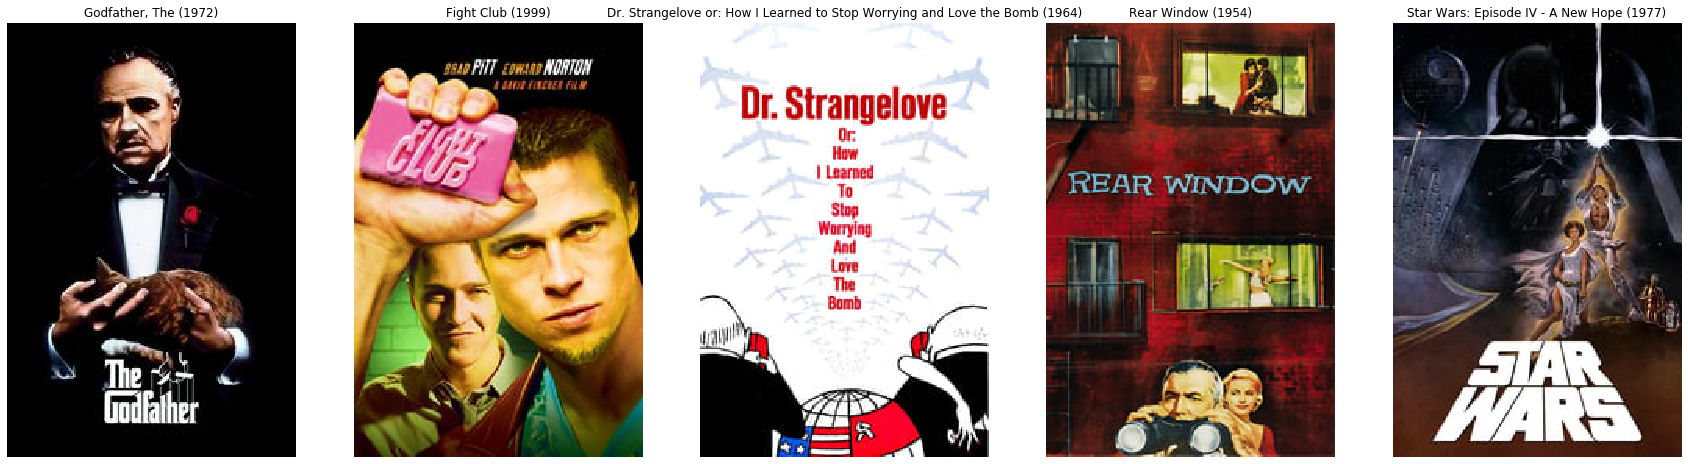

In [25]:
image=[0,0,0,0,0]
img_source=[0,0,0,0,0]
fig = plt.figure(figsize=(30,65))

user = 8;

for i in range(5):
    
    k = movies[movies['movieId']==top_n[user][i][0]].index
    image[i] = plt.subplot(1,5,i+1, title = movies['title'][k].tolist()[0])
    img_source[i] = mpimg.imread('image/' + str(top_n[user][i][0])+'.jpg')
    _ = image[i].imshow(img_source[i])
    
    image[i].axis("off")

plt.show()

In [26]:
for i in range(5):
    
    k = movies[movies['movieId']==top_n[user][i][0]].index
    print(movies['genres'][k].tolist()[0])
    

Crime|Drama
Action|Crime|Drama|Thriller
Comedy|War
Mystery|Thriller
Action|Adventure|Sci-Fi


In [27]:
movielens_dataframe[(movielens_dataframe['userId']==5) & (movielens_dataframe['rating']>3.5)]

,userId,movieId,rating,title,genres
516,5,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
517,5,21,4.0,Get Shorty (1995),Comedy|Crime|Thriller
518,5,34,4.0,Babe (1995),Children|Drama
519,5,36,4.0,Dead Man Walking (1995),Crime|Drama
521,5,50,4.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
522,5,58,5.0,"Postman, The (Postino, Il) (1994)",Comedy|Drama|Romance
523,5,110,4.0,Braveheart (1995),Action|Drama|War
526,5,232,4.0,Eat Drink Man Woman (Yin shi nan nu) (1994),Comedy|Drama|Romance
527,5,247,5.0,Heavenly Creatures (1994),Crime|Drama
529,5,261,4.0,Little Women (1994),Drama
